In [6]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Simulation parameters
RUNS = 100
NETWORK_FILE = "./networks/network_15_6.pkl"
FILEPATH_CSV = "./sim_results/avg_rmse.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 500
q = 9.5e-5  # Process noise intensity
r = 5  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

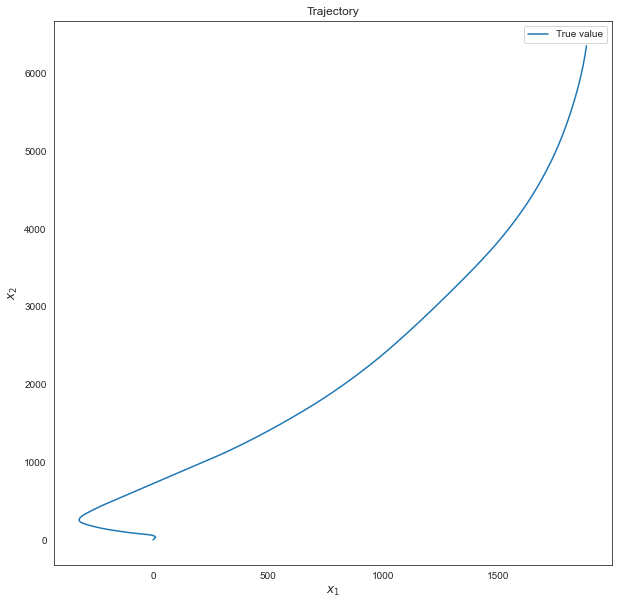

In [9]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [10]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(20 * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    # traj.simulate(ndat, INIT_STATE)
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

In [11]:
# kfn.draw_network()

In [12]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

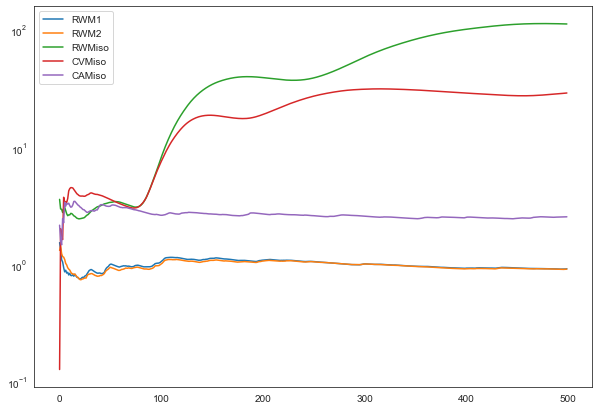

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 0], label="RWM1")
plt.plot(rmse_rwm2[:, 0], label="RWM2")

plt.plot(rmse_rwmnc[:, 0], label="RWMiso")
plt.plot(rmse_cvmnc[:, 0], label="CVMiso")
plt.plot(rmse_camnc[:, 0], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

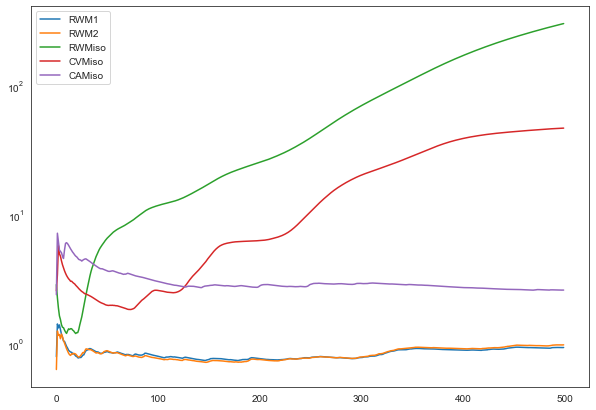

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 1], label="RWM1")
plt.plot(rmse_rwm2[:, 1], label="RWM2")

plt.plot(rmse_rwmnc[:, 1], label="RWMiso")
plt.plot(rmse_cvmnc[:, 1], label="CVMiso")
plt.plot(rmse_camnc[:, 1], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [15]:
# CSV column labels
cols = []
for n in chain(kfn._txt_labels, ["RWM_NC", "CVM_NC", "CAM_NC"]):
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

data = rmse_network(kfn, traj, ndat, 2, rwmnc, cvmnc, camnc)

In [16]:
# Generate CSV files
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_1_x1,RWM_1_x2,CVM_1_x1,CVM_1_x2,CVM_2_x1,CVM_2_x2,CVM_3_x1,CVM_3_x2,CVM_4_x1,CVM_4_x2,...,CAM_4_x1,CAM_4_x2,CAM_5_x1,CAM_5_x2,RWM_NC_x1,RWM_NC_x2,CVM_NC_x1,CVM_NC_x2,CAM_NC_x1,CAM_NC_x2
0,1.544683,0.796375,0.532516,0.911692,1.295157,0.516178,0.581115,0.903500,0.388782,0.985691,...,1.130593,0.716268,1.267687,0.283776,3.611848,2.887906,0.127615,2.582165,2.173323,2.412060
1,1.349845,1.429183,1.023096,0.739916,1.395447,0.901272,1.218597,0.813095,1.106121,0.944398,...,1.410104,1.014276,1.541322,0.704180,2.992701,2.285936,2.029680,3.428008,1.607022,7.231796
2,1.102258,1.331189,0.946497,0.852743,1.350801,0.991502,1.154595,0.970766,1.045439,1.087680,...,1.170984,1.207052,1.288436,1.115908,2.974614,1.901207,1.723978,5.780933,1.478695,6.180445
3,1.055033,1.404688,0.955628,1.192993,1.192565,1.057972,1.011628,1.119218,0.969542,1.232679,...,1.090909,1.118393,1.119694,1.102821,2.788822,1.651263,1.639509,5.006441,2.472794,5.352509
4,0.946091,1.289433,1.001742,1.076060,1.111788,0.946910,0.972007,1.006563,0.973227,1.109985,...,1.029826,1.022906,1.102409,0.986403,3.009268,1.546000,3.764315,4.790152,2.282156,5.223173
